<a href="https://colab.research.google.com/github/sciencebyAJ/OpenET_API_Training/blob/main/IA2025_OpenET_Raster_GeoTIFF_Composite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://drive.google.com/uc?export=view&id=1_TxtLd2mqSKnuwQwTV-py5Q55A6gB97d">

# **Raster GeoTIFF Composite with the API**

### [raster/geotiff/composite](https://openet.gitbook.io/docs/reference/api-reference/raster#post-raster-geotiff-composite)

#### This notebook provides a step-by-step guide to retrieve a GeoTIFF composite data from the OpenET API and visualize the difference for two time periods.

> * The Raster GeoTIFF Composite endopint supports supports queries against the OpenET monthly raster datasets and summarizes the returned data as a composite GeoTIFF. Raster datasets summarized for polygons specified by an Earth Engine asset ID, a temporary uploaded GeoJSON file, or Latitude-Longitude coordinate pairs. For more information on Earth Engine assets, see the [Earth Engine page](https://openet.gitbook.io/docs/additional-resources/earth-engine).

> * The results of this endpoint will generate a 5 minute retrieval link for a .TIFF file. Each API request to this end point will return a single GeoTIFF with the temporal aggregation (mean, max, min, ... etc.) for the requested area.
* To export a GeoTIFF for a larger region, use the [Raster Export Composite](https://openet.gitbook.io/docs/reference/api-reference/raster#post-raster-export-composite) API endpoint.


## To complete this notebook you will need:

1.   **[An OpenET account](https://account.etdata.org/login)**
2.   An OpenET **[API key](https://account.etdata.org/settings/api)**
3. A GeoJSON. This demo uses boundary covering Colusa, CA.

>   * Convert a shapefile to GeoJSON using **[MapShaper](https://mapshaper.org/)**.
  * Evaluate GeoJSON compatibility with OpenET data servicesusing **[GeoJSONLint](https://geojsonlint.com/)**


# Collab Notebook Outline

[1.   **Import Python dependencies**](https://colab.research.google.com/drive/1Jfxu9Tq2MBviFLEPghQH9OXyWlsBn5FW#scrollTo=sTU0slM2Hnta&line=1&uniqifier=1)

[2. **Configure API Key**](https://colab.research.google.com/drive/1Jfxu9Tq2MBviFLEPghQH9OXyWlsBn5FW#scrollTo=Yv7HgL5DetiU&line=5&uniqifier=1): Copy your API Key and paste in prompt to access OpenET data.


[3.   **Load boundary as GeoJSON**](https://colab.research.google.com/drive/1Jfxu9Tq2MBviFLEPghQH9OXyWlsBn5FW#scrollTo=v4Bq6YVcR-Si&line=1&uniqifier=1): Load a GeoJson and create temporary asset ID to pass Geometry to API.

[4.  **Make raster/geotiff/composite API requests & save GeoTIFFs**](https://colab.research.google.com/drive/1Jfxu9Tq2MBviFLEPghQH9OXyWlsBn5FW#scrollTo=RzIkpo6EgenZ&line=8&uniqifier=1): Construct and send a request to retrieve ET data for the defined region of interest.

[5.   **Read in GeoTIFFs and Visualize Results**](https://colab.research.google.com/drive/1Jfxu9Tq2MBviFLEPghQH9OXyWlsBn5FW#scrollTo=DxalKou3u2l-&line=41&uniqifier=1): Use *rioxarray* to read in the GeoTIFFs. Visualize the results using *matplotlib* and save a figure.



In [1]:
!pip install rioxarray rasterio --quiet
!git clone https://github.com/sciencebyAJ/OpenET_API_Training.git --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00


In [2]:
#@title 1. Import Python dependencies:
import requests
import pandas as pd
import getpass
import matplotlib.pyplot as plt
import requests
from shapely.geometry import Polygon

import os
import geopandas as gpd

In [3]:
#@title 2. Configure your API Key to access OpenET data

# @markdown #### Go to your [OpenET API account](https://account.etdata.org/settings/api) page and copy the API Key. { run: "auto" }

# @markdown #### Then paste your API Key below after running this cell

YOUR_API_KEY = getpass.getpass("Paste your API key here --> ")


header = {"Authorization": YOUR_API_KEY}

Paste your API key here --> ··········


## 3. Upload a GeoJSON to extract data

* 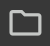 Click the folder icon to the left.

* 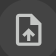 Click on the upload file icon and select the geojson from your computer.

* After the file appears in the content/ folder, right click the file & select `Copy path`

* Past the text to the `path_to_geojson: PATH/TO/sample.geojson` box below







> * GeoJSONS are limited to files < 5MB.

*Before moving on, open the Geojson inspect the attributes to pass to the attributes parameter of the API query.*

In [15]:
#@title Select GeoJSON to upload for data extraction

path_to_geojson = "/content/OpenET_API_Training/geospatial_data/arkansas_fields.geojson"

# saving region name from input geometry
region_name = path_to_geojson.split('/')[-1].split('.')[0]

gdf = gpd.read_file(path_to_geojson)
# endpoint arguments
args = {
    'file': (path_to_geojson, open(path_to_geojson, 'rb'), 'application/geo+json')
}

# query the api
resp = requests.post(
    headers=header,
    files=args,
    url="https://openet-api.org/account/upload"
)

asset_path = resp.json()['asset_id']

print('The asset_id is assigned to asset_path')

print(asset_path)


The asset_id is assigned to asset_path
https://storage.googleapis.com/openet-api-public/AJ_Purdy_263/587ddfd39ece40b38200d0120db38266


The link is a time to live link that expires in 72 hours.

## 4. Query the Raster GeoTIFF Composite endpoint to retrieve OpenET data

### raster/geotiff/composite

### **input parameters**
*   **date_range**: start and end dates formatted as: `["YYYY-MM-DD","YYYY-MM-DD"]`
*   **asset_id** or **geometry**: The asset_id can be passed as an earth engine asset path OR path to temporary cloud asset_id. Geometry can be passed as a list of longitude and latitude coordinate pairs in decimal degrees.
*   **model**: OpenET ET model to use as an input to the OTTER model. Accepted parameters include `"Ensemble"`, `"geeSEBAL"`, `"SSEBop"`, `"SIMS"`, `"DisALEXI"`, `"PTJPL"`, or `"eeMETRIC"`.
*   **variable**: Choose from `"et"`, `"eto" `,`"pr" `
*   **reference ET**: Source collection for ET reference. Choose from CIMIS (California only) or gridMET. NOAA's forecasted reference ET FRET can now be used for 7 day forecasts.
* **reducer**: Pixel aggregation method. Choose from min, max, mean, median, mode, or sum.
*   **units**: Output units. Choose from `"in"` or `"mm" `


### return
* The results of this endpoint will generate a 5 minute retrieval link for a .TIFF file.

In [20]:
DEBUG = False
#@title Make API Request & Download GeoTIFFs
print(region_name)
print(asset_path)
year = 2013
year_str = str(year)

args = {
    "date_range": [
        f"{year_str}-05-01", #adjust start / end months here
        f"{year_str}-08-30"
        ],
    "asset_id": asset_path, # geometry:[lon_1,lat_1,lon_2,lat_2 ...]
    "model": "ensemble",
    "variable": "et",
    "reference_et": "gridMET",
    "reducer": "sum", # change to sum, max, min, ...
    "units": "in"
}

# query the api
resp = requests.post(
    headers=header,
    json=args,
    url="https://openet-api.org/raster/geotiff/composite"
)

# store the result
export = resp.json()
print(resp.json())

print('This link can be accessed for 5 minutes ')
print(export['url'])

url = export['url']
# The below code saves this to the /content/ folder of the collab session
destination_folder = os.getcwd()

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

filename = f"{region_name}_{year_str}.tiff"  # Extract filename from URL
filepath = os.path.join(destination_folder, filename)

response = requests.get(url, stream=True)
response.raise_for_status()  # Raise an exception for bad status codes

with open(filepath, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"File downloaded to: {filepath}")
print(filepath)

arkansas_fields
https://storage.googleapis.com/openet-api-public/AJ_Purdy_263/587ddfd39ece40b38200d0120db38266
{'url': 'https://earthengine-highvolume.googleapis.com/v1/projects/openet/thumbnails/a086140d54a2daeae7e98df354e2a4d6-65adfca083f8ecbe4e55fbc8250516ea:getPixels'}
This link can be accessed for 5 minutes 
https://earthengine-highvolume.googleapis.com/v1/projects/openet/thumbnails/a086140d54a2daeae7e98df354e2a4d6-65adfca083f8ecbe4e55fbc8250516ea:getPixels
File downloaded to: /content/arkansas_fields_2013.tiff
/content/arkansas_fields_2013.tiff


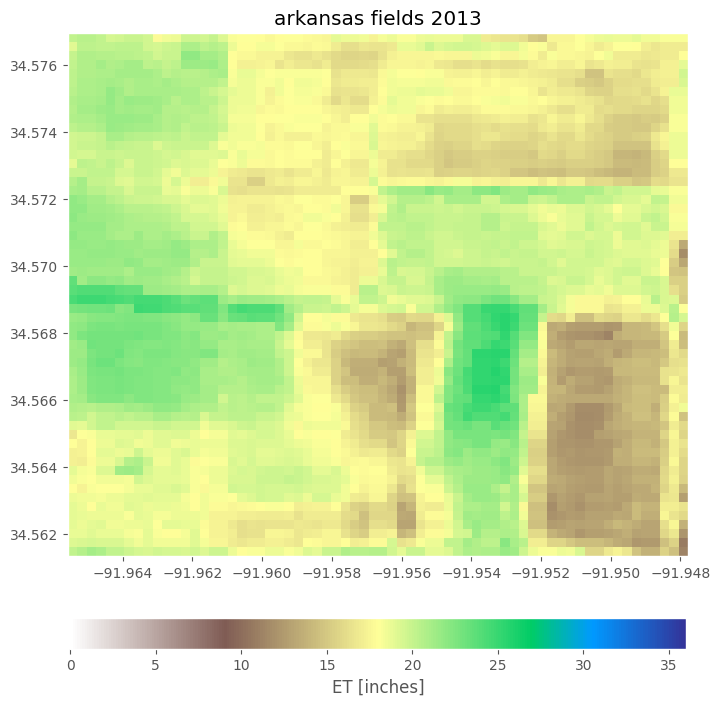

In [24]:
#@title 5. Plot Rasters and Look at Difference

import rioxarray as rxr
da = rxr.open_rasterio(filepath, masked=True).squeeze()

gdf_clip = gpd.read_file(path_to_geojson)


if da.rio.crs != gdf.crs:
    gdf_clip = gdf_clip.to_crs(da.rio.crs)

da_clip = da.rio.clip(gdf_clip.geometry, drop=True)

plt.style.use('ggplot')
fig, axs = plt.subplots(1,1, figsize=(8, 8))
im1= da_clip.plot(
    ax=axs,
    cmap="terrain_r",
    vmin=0,
    vmax=36,
    add_colorbar=False,
)


axs.set_title(' '.join(region_name.split('_'))+f" {year_str}")


axs.set_xlabel("")
axs.set_ylabel("")

cbar1 = fig.colorbar(im1, ax=axs, orientation="horizontal", fraction=0.05, pad=0.1)
cbar1.set_label("ET [inches]")

# Add separate colorbar for difference plot
axs.set_aspect("auto")   # let each subplot fill its allocated space

# plt.tight_layout()


plt.savefig(filepath.split('.')[0]+'.png')


'abjc'